In dealing with rasterization of a LiDAR data set, there are inevitably issues in dealing with cells that have missing data, especially as we force the resolution of our rasters to smaller grid cells. Inevitably, a cell will have no points within it. The tool this project uses the most, `pandas`, does not natively incorporate any methods for detecting these missing data, so we will have to cook some up ourselves.

We have already seen an example of this when creating our canopy height model:

In [2]:
%%capture
%run Canopy_Height_Model.ipynb

las = laspy.file.File("../data/sample.las")

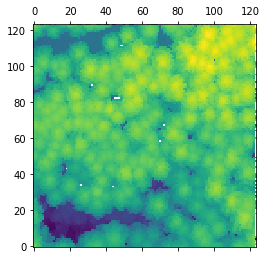

In [3]:
c = 0.8
gridded_las = grid(las, c)
matrix_plot(gridded_las)

As we can see, there are some cells with NaN values shown in white. This issue only gets worse as our cell size decreases:

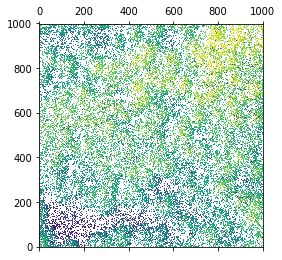

In [4]:
matrix_plot(grid(las, c = 0.1))

This issue will become paramount when we implement ground filtering algorithms, such as Zhang et al. (2003). In fact, many ground filtering algorithms suggest interpolating these missing values as a subroutine in the algorithm. Before we begin, we need to find which points are the minimums in their respective cells. This will not come into play until later on, but is easy to get out of the way now with a few transformations of our 

In [5]:
# Flag the points that are the minimum z value for their cell
idx = gridded_las.groupby(['bins_x', 'bins_y'])['z'].transform(max) == gridded_las['z']
gridded_las['max_z'] = idx

# Select the points that are minimums as a new dataframe.
min_points = gridded_las.loc[gridded_las['max_z']]
min_points.head()

,bins_x,bins_y,x,y,z,max_z
111,2,9,470096.05,5016471.96,514.74,True
133,1,22,470095.53,5016481.95,513.44,True
153,1,49,470094.98,5016504.57,519.30,True
158,1,38,470095.06,5016495.15,510.44,True
208,2,8,470096.35,5016470.65,514.10,True


Next, to simplify detection of missing values, we sort the  dataframe by `bins_x` and `bins_y`.

In [6]:
grouped_sort = min_points.sort_values(['bins_x', 'bins_y'])
grouped_sort.head()

,bins_x,bins_y,x,y,z,max_z
413589,1,1,470095.12,5016464.96,524.89,True
413586,1,2,470094.99,5016466.35,522.80,True
108005,1,3,470095.28,5016466.72,521.41,True
108003,1,4,470094.97,5016467.42,519.86,True
107958,1,5,470095.47,5016468.14,518.97,True


We can now reduce the problem to finding missing pairs of `bins_x` and `bins_y` by examining each unique value of `bins_x`, ensuring that all bins of y (1 through `m`) are present, and if not recording which ones are missing. To do this we need some helper functions.

The first is `missing_elements`. This detects missing values in a series of integers (provided as a list). This is tied together with the `find_missing_cells` function, that handles some array munging and assists in recording pairs that are missing.

One important simplification: if we know a bin from `bins_x` is missing entirely, this means that no point ever falls within all the bins in that "column", i.e. a point never falls in any y bin either, so we can instantly record any missing `bins_x` and all of their associated `bins_y` values outright. This is the first section of `find_missing_cells`. This will very rarely be the case in reality, but we should build in robustness here just in case.

In [7]:
n, m = calc_dims(las, c)

def missing_elements(L, max_val):
    start, end = L[0], max_val
    return(sorted(set(range(start, end + 1)).difference(L)))

def find_missing_cells(max_x, sorted_groups):
    # Initialize an array container
    arr = np.empty((0, 2))
    for x_bin in range(1, m):    
        # Subset the dataframe for each value of x_bin
        bin_x = sorted_groups.loc[sorted_groups['bins_x'] == x_bin]
        
        # Construct a list to feed to missing_elements and get the missing elements
        L = list(bin_x['bins_y'])
        missing = missing_elements(L, int(m))
        
        # Create numpy array of the missing x_bin and y_bins
        ones = np.full(len(missing), x_bin)
        vals = np.array(missing)
        stacked = np.stack((ones, vals), axis = 1)
        
        # Append to the container array
        arr = np.append(arr, stacked, axis = 0)
    return(arr)

missing_cells = find_missing_cells(n, grouped_sort)
missing_cells[0:30]

array([[   1.,  124.],
       [   2.,  124.],
       [   4.,  124.],
       [   7.,  124.],
       [   9.,  124.],
       [  11.,  124.],
       [  12.,  124.],
       [  14.,  124.],
       [  15.,  124.],
       [  16.,  124.],
       [  17.,  124.],
       [  18.,  124.],
       [  19.,   44.],
       [  19.,  124.],
       [  20.,  124.],
       [  24.,  124.],
       [  27.,   35.],
       [  28.,  124.],
       [  29.,  124.],
       [  33.,   90.],
       [  33.,  124.],
       [  34.,  124.],
       [  35.,  124.],
       [  39.,  124.],
       [  43.,  124.],
       [  44.,  124.],
       [  45.,   34.],
       [  46.,   83.],
       [  47.,   83.],
       [  47.,  124.]])

Great, now we have something to work with. In the case of Zhang et al. (2003), we want to go a bit further than this. We need to interpolate these missing values cells, however. `scipy.interpolate.griddata` does well to serve this purpose. But first, we need a 2D array of all the possible grid cells.

In [11]:
X, Y = np.mgrid[1:n+1, 1:m+1]
positions = np.stack([X.ravel(), Y.ravel()], axis = 1)


positions

array([[  1,   1],
       [  1,   2],
       [  1,   3],
       ..., 
       [124, 122],
       [124, 123],
       [124, 124]])

Now that we have the non-empty cells with their respective values (in `grouped_sort`), the empty cells (in `missing_cells`), and an array of all possible cell positions (in `positions`), we can proceed to interpolating. 

In [25]:
from scipy.interpolate import griddata

# Call griddata
interp_grid = griddata(grouped_sort[['bins_x', 'bins_y']].values, grouped_sort['z'].values, positions,
                      method = "nearest")

# Reshape into proper size
interp_matrix = interp_grid.reshape(m, n).T
interp_matrix

array([[ 524.89,  524.03,  519.79, ...,  522.21,  522.13,  522.13],
       [ 522.8 ,  522.36,  520.49, ...,  524.07,  525.17,  525.23],
       [ 521.41,  521.02,  520.43, ...,  525.45,  525.81,  525.23],
       ..., 
       [ 523.51,  523.49,  522.41, ...,  534.29,  535.95,  534.02],
       [ 524.58,  524.81,  522.53, ...,  533.88,  534.73,  534.73],
       [ 524.58,  524.81,  521.07, ...,  533.88,  534.73,  534.73]])

Excellent. Now we can compare our new data to the original, problematic data.

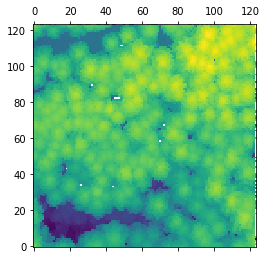

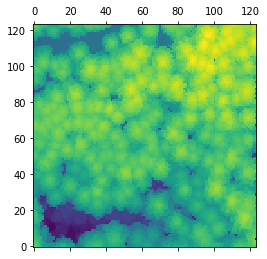

In [26]:
# Plot original matrix
matrix_plot(grouped_sort)

# Plot new matrix
plt.matshow(interp_matrix)
plt.gca().invert_yaxis()
plt.show()

The top plot shows the raw grid, with all of its missing cell values in white, and the bottom is the finished product, a raster with no holes. Although the example here uses the canopy height model (i.e. maximum z value), this subroutine can be used in a variety of applications, including the Zhang et al. (2003) ground filter.